### Lab04 Yolov3

In [3]:
!wget https://github.com/ayooshkathuria/pytorch-yolo-v3/raw/master/dog-cycle-car.png

--2021-03-09 16:03:29--  https://github.com/ayooshkathuria/pytorch-yolo-v3/raw/master/dog-cycle-car.png
Connecting to 192.41.170.23:3128... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ayooshkathuria/pytorch-yolo-v3/master/dog-cycle-car.png [following]
--2021-03-09 16:03:30--  https://raw.githubusercontent.com/ayooshkathuria/pytorch-yolo-v3/master/dog-cycle-car.png
Connecting to 192.41.170.23:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 347445 (339K) [image/png]
Saving to: ‘dog-cycle-car.png’

dog-cycle-car.png   100%[===================>] 339.30K  --.-KB/s    in 0.1s    

2021-03-09 16:03:30 (2.26 MB/s) - ‘dog-cycle-car.png’ saved [347445/347445]



In [9]:
!wget https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/detect.py

--2021-03-09 16:08:09--  https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/detect.py
Connecting to 192.41.170.23:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 7273 (7.1K) [text/plain]
Saving to: ‘detect.py.1’

detect.py.1         100%[===================>]   7.10K  --.-KB/s    in 0s      

2021-03-09 16:08:09 (50.0 MB/s) - ‘detect.py.1’ saved [7273/7273]



In [5]:
!wget https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/darknet.py
!wget https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/util.py

--2021-03-10 01:10:06--  https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/util.py
Connecting to 192.41.170.23:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 7432 (7.3K) [text/plain]
Saving to: ‘util.py.1’

util.py.1           100%[===================>]   7.26K  --.-KB/s    in 0s      

2021-03-10 01:10:07 (34.5 MB/s) - ‘util.py.1’ saved [7432/7432]



In [4]:
!cp dog-cycle-car.png cocoimages/

In [1]:
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2 
from util import *
import argparse
import os 
import os.path as osp
from darknet import Darknet
import pickle as pkl
import pandas as pd
import random

images = "cocoimages"
batch_size = 4
confidence = 0.5
nms_thesh = 0.4
start = 0
CUDA = torch.cuda.is_available()

num_classes = 80
classes = load_classes("data/coco.names")

#Set up the neural network

print("Loading network.....")
model = Darknet("cfg/yolov3.cfg")
model.load_weights("weights/yolov3.weights")
model.load_weights("weights/yolov3.weights")
print("Network successfully loaded")

model.net_info["height"] = 416
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32

#If there's a GPU availible, put the model on GPU

if CUDA:
    model.cuda()

# Set the model in evaluation mode

model.eval()

read_dir = time.time()

# Detection phase

try:
    imlist = [osp.join(osp.realpath('.'), images, img) for img in os.listdir(images)]
except NotADirectoryError:
    imlist = []
    imlist.append(osp.join(osp.realpath('.'), images))
except FileNotFoundError:
    print ("No file or directory with the name {}".format(images))
    exit()
    
if not os.path.exists("des"):
    os.makedirs("des")

load_batch = time.time()
loaded_ims = [cv2.imread(x) for x in imlist]

im_batches = list(map(prep_image, loaded_ims, [inp_dim for x in range(len(imlist))]))
im_dim_list = [(x.shape[1], x.shape[0]) for x in loaded_ims]
im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)


leftover = 0
if (len(im_dim_list) % batch_size):
    leftover = 1

if batch_size != 1:
    num_batches = len(imlist) // batch_size + leftover            
    im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size,
                        len(im_batches))]))  for i in range(num_batches)]  

write = 0

if CUDA:
    im_dim_list = im_dim_list.cuda()
    
start_det_loop = time.time()
for i, batch in enumerate(im_batches):
    # Load the image 
    start = time.time()
    if CUDA:
        batch = batch.cuda()
    with torch.no_grad():
        prediction = model(Variable(batch), CUDA)

    prediction = write_results(prediction, confidence, num_classes, nms_conf = nms_thesh)

    end = time.time()

    if type(prediction) == int:

        for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
            im_id = i*batch_size + im_num
            print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
            print("{0:20s} {1:s}".format("Objects Detected:", ""))
            print("----------------------------------------------------------")
        continue

    prediction[:,0] += i*batch_size    #transform the atribute from index in batch to index in imlist 

    if not write:                      #If we have't initialised output
        output = prediction  
        write = 1
    else:
        output = torch.cat((output,prediction))

    for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
        im_id = i*batch_size + im_num
        objs = [classes[int(x[-1])] for x in output if int(x[0]) == im_id]
        print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
        print("{0:20s} {1:s}".format("Objects Detected:", " ".join(objs)))
        print("----------------------------------------------------------")

    if CUDA:
        torch.cuda.synchronize()       
try:
    output
except NameError:
    print ("No detections were made")
    exit()

im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())

scaling_factor = torch.min(416/im_dim_list,1)[0].view(-1,1)

output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2

output[:,1:5] /= scaling_factor

for i in range(output.shape[0]):
    output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
    output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])
    
output_recast = time.time()
class_load = time.time()
colors = [[255, 0, 0], [255, 0, 0], [255, 255, 0], [0, 255, 0], [0, 255, 255], [0, 0, 255], [255, 0, 255]]

draw = time.time()

def write(x, results):
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    img = results[int(x[0])]
    cls = int(x[-1])
    color = random.choice(colors)
    label = "{0}".format(classes[cls])
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);
    return img


list(map(lambda x: write(x, loaded_ims), output))

det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format("des",x.split("/")[-1]))

list(map(cv2.imwrite, det_names, loaded_ims))

end = time.time()

print("SUMMARY")
print("----------------------------------------------------------")
print("{:25s}: {}".format("Task", "Time Taken (in seconds)"))
print()
print("{:25s}: {:2.3f}".format("Reading addresses", load_batch - read_dir))
print("{:25s}: {:2.3f}".format("Loading batch", start_det_loop - load_batch))
print("{:25s}: {:2.3f}".format("Detection (" + str(len(imlist)) +  " images)", output_recast - start_det_loop))
print("{:25s}: {:2.3f}".format("Output Processing", class_load - output_recast))
print("{:25s}: {:2.3f}".format("Drawing Boxes", end - draw))
print("{:25s}: {:2.3f}".format("Average time_per_img", (end - load_batch)/len(imlist)))
print("----------------------------------------------------------")


torch.cuda.empty_cache()

Loading network.....
Network successfully loaded
dog-cycle-car.png    predicted in  0.020 seconds
Objects Detected:    bicycle truck dog
----------------------------------------------------------
SUMMARY
----------------------------------------------------------
Task                     : Time Taken (in seconds)

Reading addresses        : 0.001
Loading batch            : 0.021
Detection (1 images)     : 0.085
Output Processing        : 0.000
Drawing Boxes            : 0.078
Average time_per_img     : 0.183
----------------------------------------------------------


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors', 'unique', 'draw', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


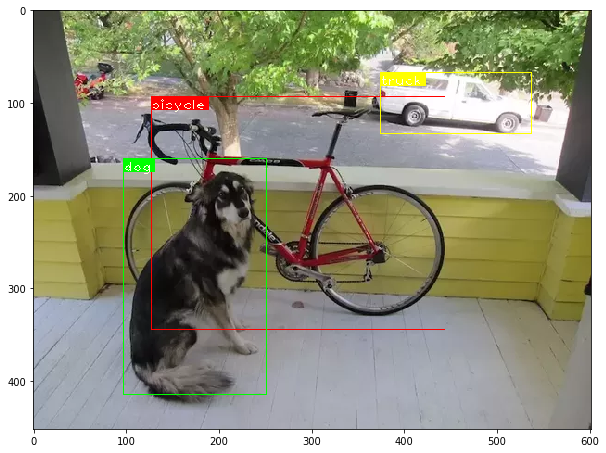

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("des/det_dog-cycle-car.png")
plt.figure(figsize = (10,10))
plt.imshow(image)
plt.show()